In [30]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping

In [31]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
training = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/training_new.csv")
validation = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/validation_new.csv")
print(len(training),len(validation))

1102605 127440


In [33]:
# 훈련 데이터와 테스트 데이터 합치기 ==> 추후 분리할 예정
training = pd.concat([training,validation])
len(training)

1230045

In [34]:
training.sample(10)

,Unnamed: 0,standard,dialect
247820,247820,사람도 많은데,사람도 많은디
155562,155562,저가 고일 때 고일 때 그 저가 엄마아빠랑 싸웠어요,저가 고일 때 고일 때 그 저가 엄마아빠랑 싸워수다
119998,119998,나 나 나 결혼은 말하지도 마십시오,나 나 나 결혼은 고찌도 맙써
382614,382614,아니 아빠 지식인 답변이 진짜 슬프지 아 나 장난 아니네,아니 아빠 지식인 답변이 진짜 슬프지 아 나 장난 아닌게
720541,720541,나 목소리 너무 크게 들리나,나 목소리 너무 크게 들렴신가
467192,467192,묻어 게 어떻게 된 것인지 그래서 나한테,묻어 게 어떠나산디 게난 나신디
315783,315783,조바심내는 사람은 산짓물에 가도,자드는 사람은 산짓물에 가도
165636,165636,동생는 나보다 좀 작으난이 잘할 거 같다 그렇게하면이,아시는 나보다 좀 좀지난이 잘허커라 경허믄이
961401,961401,그 예전에 생각했던 그 꿈을 버리지 못해서 열심히 살아야지 열심히 살아야지 하다 보니까,그 예전에 생각했던 그 꿈을예 버리지 못해영 열심히 살아야지 열심히 살아야지 허당 보난게
190566,190566,날씨도 많이 춥지 않아,날씨도 많이 춥지 않애


In [35]:
# 10만개만 시범적으로(제주->표준어)
standard_input = training.dialect[:100000]
dialect_input = training.standard[:100000].apply(lambda x: "<sos>" + " "+ str(x))
dialect_output = training.standard[:100000].apply(lambda x: str(x) + " "+ "<eos>" )

In [36]:
src_input = []
for sentence in tqdm(standard_input):
  result = []
  for word in str(sentence).split():
    result.append(word)
  src_input.append(result)

100%|██████████| 100000/100000 [00:00<00:00, 381001.10it/s]


In [37]:
tar_input = []
for sentence in tqdm(dialect_input):
  result = []
  for word in str(sentence).split():
    result.append(word)
  tar_input.append(result)

100%|██████████| 100000/100000 [00:00<00:00, 137734.38it/s]


In [38]:
tar_output = []
for sentence in tqdm(dialect_output):
  result = []
  for word in str(sentence).split():
    result.append(word)
  tar_output.append(result)

100%|██████████| 100000/100000 [00:00<00:00, 162304.51it/s]


In [39]:
tokenizer_src = Tokenizer()
tokenizer_src.fit_on_texts(src_input)
encoder_input = tokenizer_src.texts_to_sequences(src_input)

tokenizer_tar = Tokenizer()
tokenizer_tar.fit_on_texts(tar_input)
decoder_input = tokenizer_tar.texts_to_sequences(tar_input)

tokenizer_tar.fit_on_texts(tar_output)
decoder_output = tokenizer_tar.texts_to_sequences(tar_output)

문장 최대 길이: 88
문장 평균 길이: 6.49118


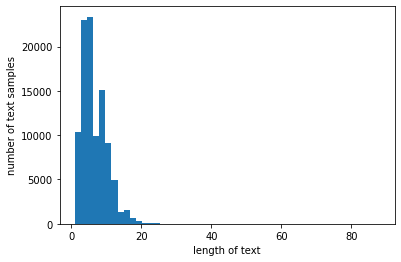

In [40]:
print("문장 최대 길이:", max(len(text) for text in encoder_input))
print("문장 평균 길이:", sum(map(len,encoder_input))/len(encoder_input))
plt.hist([len(text) for text in encoder_input],bins = 50)
plt.xlabel("length of text")
plt.ylabel("number of text samples")
plt.show()

In [41]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for text in nested_list:
    if len(text) <= max_len:
      count += 1
  print("전체 샘플의 길이가 {} 이하인 샘플의 비율: {}".format(max_len, (count / len(nested_list))*100))

In [42]:
max_len = 25
below_threshold_len(max_len, encoder_input)
below_threshold_len(max_len, decoder_input)
below_threshold_len(max_len, decoder_output)

전체 샘플의 길이가 25 이하인 샘플의 비율: 99.926
전체 샘플의 길이가 25 이하인 샘플의 비율: 99.90599999999999
전체 샘플의 길이가 25 이하인 샘플의 비율: 99.90599999999999


In [43]:
encoder_input = pad_sequences(encoder_input,padding="post",maxlen = max_len)
decoder_input = pad_sequences(decoder_input, padding = "post", maxlen = max_len)
decoder_target = pad_sequences(decoder_output,padding="post", maxlen = max_len)

In [44]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (100000, 25)
디코더의 입력의 크기(shape) : (100000, 25)
디코더의 레이블의 크기(shape) : (100000, 25)


In [45]:
src_vocab_size = len(tokenizer_src.word_index) + 1
tar_vocab_size = len(tokenizer_tar.word_index) + 1
print("표준어 단어 집합의 크기 : {:d}, 제주방언 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

표준어 단어 집합의 크기 : 128836, 제주방언 단어 집합의 크기 : 104924


In [46]:
# 단어->정수 & 정수->단어 딕셔너리
src_to_index = tokenizer_src.word_index
index_to_src = tokenizer_src.index_word
tar_to_index = tokenizer_tar.word_index
index_to_tar = tokenizer_tar.index_word

In [47]:
# 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [78669  6368 25758 ... 88644 56529 58221]


In [48]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### 훈련데이터와 테스트 데이터 분리



In [49]:
encoder_input_train = encoder_input[:80000]
decoder_input_train = decoder_input[:80000]
decoder_target_train = decoder_target[:80000]

encoder_input_test = encoder_input[80000:]
decoder_input_test = decoder_input[80000:]
decoder_target_test = decoder_target[80000:]

### 모델 설계하기

In [50]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [51]:
embedding_dim = 64
hidden_units = 64

In [52]:
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [53]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [25]:
#early_stopping = EarlyStopping(monitor="val_loss", min_delta = 0, patience = 10, mode = "auto")
#hist = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
#          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
#          batch_size=200, epochs=70,callbacks=[early_stopping])

In [26]:
# 모델 저장하기
from keras.models import save
model.save("jeju_model_jeju2standard.h5")

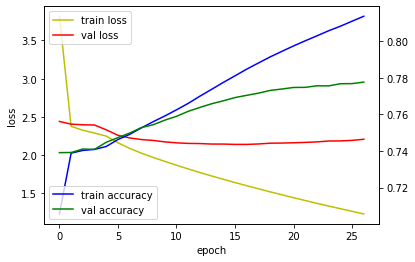

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(hist.history['acc'], 'b', label = 'train accuracy')
acc_ax.plot(hist.history['val_acc'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('acc')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

In [54]:
# 모델 불러오기
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab_Notebooks/jeju_model_jeju2standard.h5")

In [62]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     8245504     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     6715136     ['input_2[0][0]']                
                                                                                              

In [32]:
lose, mse = model.evaluate([encoder_input_test, decoder_input_test],decoder_target_test )

625/625 [==============================] - 85s 133ms/step - loss: 1.3848 - acc: 0.8104


In [56]:
# y_hat = model.predict([encoder_input_test, decoder_input_test])

In [58]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [59]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [60]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [65]:
print(encoder_input_train[1000])
print(decoder_input_train[1000])

[   901     20      4     65      7   3066     23      5 122394      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0]
[    1   736    23     3    78    11  2342    32     8 99826     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


In [64]:
for seq_index in [1000, 221, 2500, 2, 333]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : 하긴 근데 이 사람 다 장사 잘 안 되나믄 
정답문장 : 돼요 그래서 그 그래도 우리 고운 있어 이렇게 낮술도 
번역문장 : 트는거야 멀어 있더라게 프라이 재작년 까지는 맞는거 리듬 조상님 산방식당 피하고 해
--------------------------------------------------
입력문장 : 숨쉬기 너무 힘든거라 이게 맞지 
정답문장 : 가프지 하는 세번 몇 할머니가 
번역문장 : 트는거야 멀어 있더라게 프라이 재작년 까지는 맞는거 리듬 조상님 산방식당 피하고 해
--------------------------------------------------
입력문장 : 너 울어샤 
정답문장 : 야 않냐 
번역문장 : 트는거야 멀어 있더라게 프라이 재작년 까지는 맞는거 리듬 조상님 산방식당 피하고 해
--------------------------------------------------
입력문장 : 사람들이 아이구 잘도 깊이 들어감쪄이 저 이십미터 
정답문장 : 빨리 엄마가 그러게 보던 느껴야 나 기술도 
번역문장 : 트는거야 멀어 있더라게 프라이 재작년 까지는 맞는거 리듬 조상님 산방식당 피하고 해
--------------------------------------------------
입력문장 : 골레기 같은 그 노루 새끼 두 마리가 
정답문장 : 조카가 약간 될지 어저께 그래 어땠어 
번역문장 : 트는거야 멀어 있더라게 프라이 재작년 까지는 맞는거 리듬 조상님 산방식당 피하고 해
--------------------------------------------------
